acceptance rate: 0.6537333333333334
posterior mean: [ 0.2606565   1.24944808 -1.10949659]
posterior median: [ 0.25813655  1.24431184 -1.10723967]
true beta: [ 0.4  1.2 -0.9]


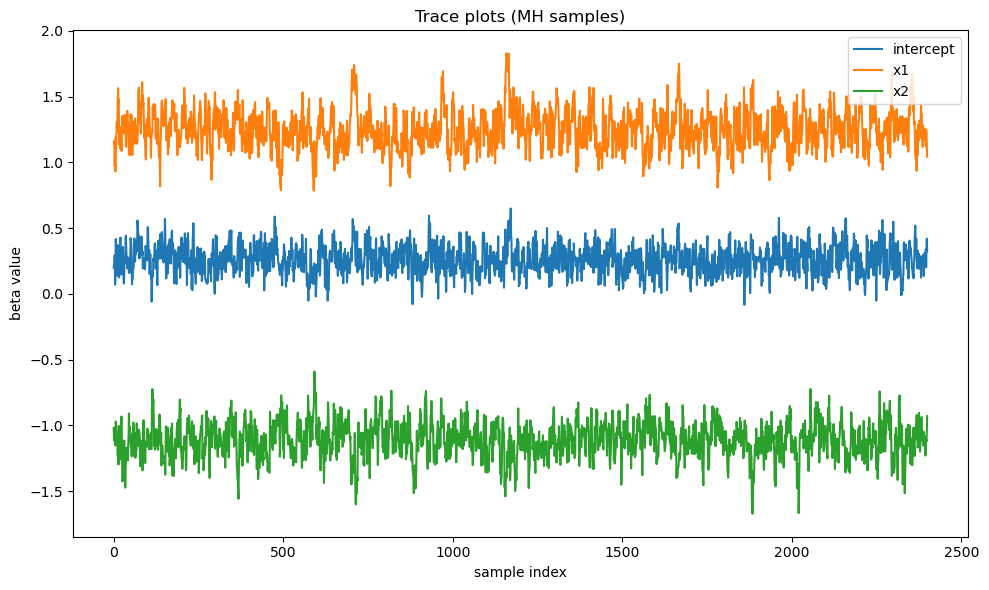

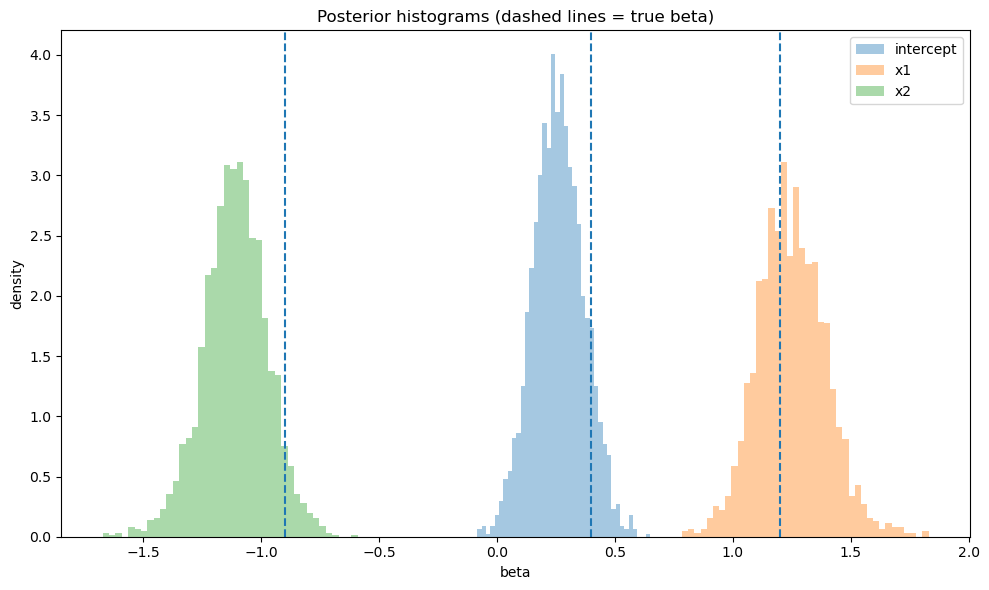

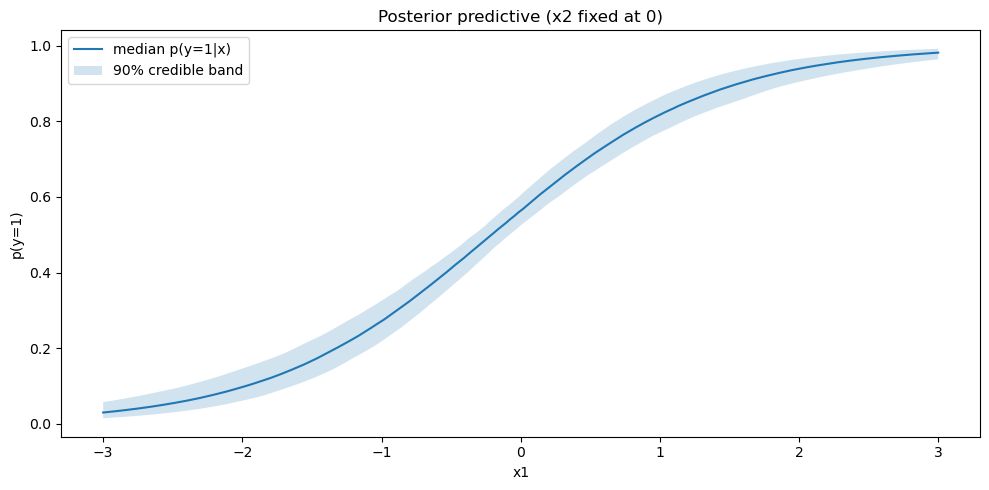

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) ダミーデータ生成（2特徴 + 切片）
# -----------------------------
np.random.seed(0)

N = 500
X_raw = np.random.randn(N, 2)
X = np.c_[np.ones(N), X_raw]  # 切片を追加（shape: N x 3）

beta_true = np.array([0.4, 1.2, -0.9])  # 真の係数（切片, x1, x2）
logit = X @ beta_true
p_true = 1.0 / (1.0 + np.exp(-logit))
y = (np.random.rand(N) < p_true).astype(int)

# -----------------------------
# 1) 事前分布：beta ~ N(0, sigma_prior^2 I)
#    尤度：Bernoulli(sigmoid(X beta))
# -----------------------------
def sigmoid(z):
    # オーバーフロー対策（大きいzをクリップ）
    z = np.clip(z, -30, 30)
    return 1.0 / (1.0 + np.exp(-z))

def log_prior(beta, sigma_prior=2.0):
    # N(0, sigma^2 I) の対数密度（定数項は捨ててもOK）
    return -0.5 * np.sum((beta / sigma_prior) ** 2)

def log_lik(beta, X, y):
    p = sigmoid(X @ beta)
    # log Bernoulli likelihood
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def log_post(beta, X, y, sigma_prior=2.0):
    return log_lik(beta, X, y) + log_prior(beta, sigma_prior)

# -----------------------------
# 2) Metropolis-Hastings（ランダムウォーク）
# -----------------------------
def mh_logistic(X, y, n_samples=12000, burn=2000, thin=5, step=0.08, sigma_prior=2.0):
    d = X.shape[1]
    beta = np.zeros(d)
    lp = log_post(beta, X, y, sigma_prior=sigma_prior)

    chain = []
    acc = 0
    total = 0

    for t in range(n_samples):
        prop = beta + np.random.randn(d) * step
        lp_prop = log_post(prop, X, y, sigma_prior=sigma_prior)

        # 受理確率 min(1, exp(lp_prop - lp))
        if np.log(np.random.rand()) < (lp_prop - lp):
            beta = prop
            lp = lp_prop
            acc += 1
        total += 1

        if t >= burn and ((t - burn) % thin == 0):
            chain.append(beta.copy())

    chain = np.array(chain)
    acc_rate = acc / total
    return chain, acc_rate

chain, acc_rate = mh_logistic(X, y, n_samples=15000, burn=3000, thin=5, step=0.07, sigma_prior=2.0)
print("acceptance rate:", acc_rate)
beta_mean = chain.mean(axis=0)
beta_med  = np.median(chain, axis=0)
print("posterior mean:", beta_mean)
print("posterior median:", beta_med)
print("true beta:", beta_true)

# -----------------------------
# 3) プロット（trace / hist / 予測の不確実性）
# -----------------------------
names = ["intercept", "x1", "x2"]

# (A) トレースプロット
plt.figure(figsize=(10, 6))
for i in range(chain.shape[1]):
    plt.plot(chain[:, i], label=names[i])
plt.title("Trace plots (MH samples)")
plt.xlabel("sample index")
plt.ylabel("beta value")
plt.legend()
plt.tight_layout()
plt.show()

# (B) 事後分布（ヒストグラム）＋真値の縦線
plt.figure(figsize=(10, 6))
for i in range(chain.shape[1]):
    plt.hist(chain[:, i], bins=40, alpha=0.4, density=True, label=names[i])
    plt.axvline(beta_true[i], linestyle="--")
plt.title("Posterior histograms (dashed lines = true beta)")
plt.xlabel("beta")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

# (C) 予測確率の不確実性（x2=0固定、x1をスイープ）
x1_grid = np.linspace(-3, 3, 200)
x2_fixed = 0.0
Xg = np.c_[np.ones_like(x1_grid), x1_grid, np.full_like(x1_grid, x2_fixed)]

# 事後サンプルから予測確率を作る
# たくさん使うと重いので、間引いて使う
idx = np.linspace(0, len(chain) - 1, 400).astype(int)
p_samples = sigmoid(Xg @ chain[idx].T)  # shape: (grid, draws)

p_med = np.median(p_samples, axis=1)
p_lo  = np.quantile(p_samples, 0.05, axis=1)
p_hi  = np.quantile(p_samples, 0.95, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(x1_grid, p_med, label="median p(y=1|x)")
plt.fill_between(x1_grid, p_lo, p_hi, alpha=0.2, label="90% credible band")
plt.title("Posterior predictive (x2 fixed at 0)")
plt.xlabel("x1")
plt.ylabel("p(y=1)")
plt.legend()
plt.tight_layout()
plt.show()
